## Final Project Submission

* Student name: Qilun Chen, Evan Serrano
* Student pace: full time
* Scheduled project review date/time: April/1/2022
* Instructor name: Praveen Gowtham, Joe Comeaux
* Blog post URL:https://github.com/nkbuddy/dsc-phase-2-project-NYC


# WHAT FACTORS ARE DRIVING PRICE?


WHAT TOOLS CAN WE USE TO EVALUATE? 


WHAT FEATURES ARE RELATED TO EACH OTHER?


WHAT FEATURES CAN PREDICT PRICE?


In [464]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.ticker import StrMethodFormatter
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats
from sklearn.preprocessing import StandardScaler

%matplotlib inline

# Data cleaning

In [465]:
data = pd.read_csv('data/kc_house_data.csv')
data.head()


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [466]:
data['grade'].unique()

array(['7 Average', '6 Low Average', '8 Good', '11 Excellent', '9 Better',
       '5 Fair', '10 Very Good', '12 Luxury', '4 Low', '3 Poor',
       '13 Mansion'], dtype=object)

In [467]:
data.shape

(21597, 21)

In [468]:
data.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [469]:
data.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront        object
view              object
condition         object
grade             object
sqft_above         int64
sqft_basement     object
yr_built           int64
yr_renovated     float64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

change sqft_basement from object to float

In [470]:
data.loc[:, 'sqft_basement'] = data['sqft_basement'].str.replace("?","0.0")
data.loc[:, 'sqft_basement'] = data['sqft_basement'].astype('float64')

/var/folders/8y/cslj48jd39z6f0kr2m9qqjy00000gn/T/ipykernel_76621/327206397.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data.loc[:, 'sqft_basement'] = data['sqft_basement'].str.replace("?","0.0")


replace NaN in view to NONE

In [471]:
data['view'] = data['view'].fillna('NONE')

replace NaN in waterfront to NO



In [472]:
data['waterfront'] = data['waterfront'].fillna('NO')

replace NaN in yr_renovated to 0

In [473]:
data['yr_renovated'] = data['yr_renovated'].fillna(0)

check how many NaN in data



In [474]:
data.isna().sum().sum()

0

drop lat column and long column in data

In [475]:
data.drop(columns = 'lat', inplace = True)


In [476]:
data.drop(columns = 'long', inplace = True)

chreate new columns livingAreaRatio, year_sold, houseAge, pricePerSqft

In [477]:
data['livingAreaRatio'] = data['sqft_living'] / data['sqft_lot']

In [478]:
data['date'] = pd.to_datetime(data['date'])
data['year_sold'] = data['date'].dt.year

In [479]:
data['houseAge'] = data['year_sold'] - data['yr_built']

In [480]:
data['pricePerSqft'] = data['price'] / data['sqft_lot']

change columns waterfront, view, condition, grade to Ordinal encoding



In [481]:
data['waterfront'] = pd.get_dummies(data['waterfront'], drop_first = True)

In [482]:
data['view'] = data['view'].astype('category')

In [483]:
data['view'] = data['view'].cat.reorder_categories(['NONE', 'FAIR', 'AVERAGE', 'GOOD', 'EXCELLENT'])


In [484]:
data['view'] = data['view'].cat.codes


In [485]:
data['condition'] = data['condition'].astype('category')


In [486]:
data['condition'] = data['condition'].cat.codes


In [487]:
data['grade'] = data.apply(lambda x:int(x['grade'][0:2].replace(' ','')),axis = 1)

### Drop the unnecessary columns, "ID" and "Date"

In [488]:
data.drop(['id','date'],axis=1,inplace=True)

### To remove outliner

In [489]:
def find_outliers(col):
    z = np.abs(stats.zscore(col))
    idx_outliers = np.where(z>3.49,True,False)
    return pd.Series(idx_outliers,index=col.index)

In [490]:
df_test = pd.DataFrame()
for col in data.drop(['zipcode'], axis=1).columns:
    idx = find_outliers(data[col])
    df_test[col] = idx

In [491]:
idx_all_outliers = df_test.any(axis=1)
df_clean = data[idx_all_outliers==False]
df_clean

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_basement,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15,livingAreaRatio,year_sold,houseAge,pricePerSqft
0,221900.0,3,1.00,1180,5650,1.0,0,0,0,7,...,0.0,1955,0.0,98178,1340,5650,0.208850,2014,59,39.274336
2,180000.0,2,1.00,770,10000,1.0,0,0,0,6,...,0.0,1933,0.0,98028,2720,8062,0.077000,2015,82,18.000000
3,604000.0,4,3.00,1960,5000,1.0,0,0,4,7,...,910.0,1965,0.0,98136,1360,5000,0.392000,2014,49,120.800000
4,510000.0,3,2.00,1680,8080,1.0,0,0,0,8,...,0.0,1987,0.0,98074,1800,7503,0.207921,2015,28,63.118812
6,257500.0,3,2.25,1715,6819,2.0,0,0,0,7,...,0.0,1995,0.0,98003,2238,6819,0.251503,2014,19,37.762135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21591,475000.0,3,2.50,1310,1294,2.0,0,0,0,8,...,130.0,2008,0.0,98116,1330,1265,1.012365,2015,7,367.078825
21593,400000.0,4,2.50,2310,5813,2.0,0,0,0,8,...,0.0,2014,0.0,98146,1830,7200,0.397385,2015,1,68.811285
21594,402101.0,2,0.75,1020,1350,2.0,0,0,0,7,...,0.0,2009,0.0,98144,1020,2007,0.755556,2014,5,297.852593
21595,400000.0,3,2.50,1600,2388,2.0,0,0,0,8,...,0.0,2004,0.0,98027,1410,1287,0.670017,2015,11,167.504188


In [492]:
df_clean.shape

(18951, 21)

# Exploring the Data

Create heatmap

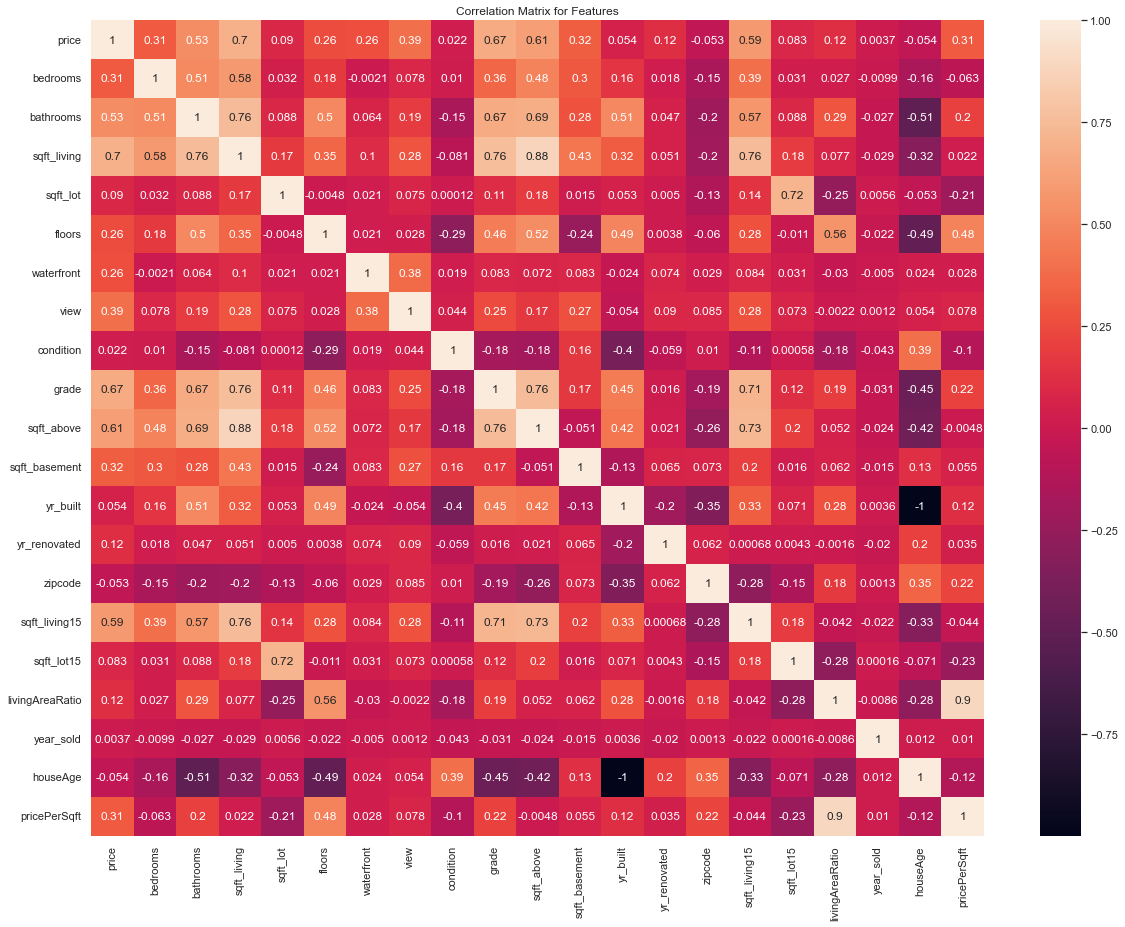

In [493]:
plt.figure(figsize = (20, 15))
sns.set(style="white")
sns.heatmap(data.corr(), annot = True)


plt.title('Correlation Matrix for Features')
plt.savefig("corrmat.jpg" , dpi=300)
plt.show()

Highly correlated variables: Sqft_Above vs sqft_living
Drop: Sqft_Above

In [494]:
df_clean.drop(['sqft_above'],axis=1,inplace=True)

/var/folders/8y/cslj48jd39z6f0kr2m9qqjy00000gn/T/ipykernel_76621/3810893269.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean.drop(['sqft_above'],axis=1,inplace=True)


## Focus on Grade, Sqft_Living, Sqft_Living15

Create scatter plot

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='grade', ylabel='price'>

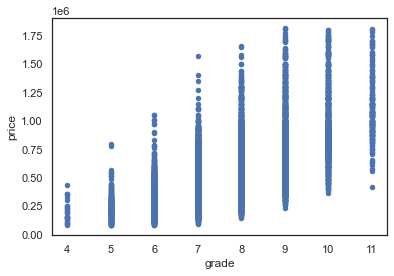

In [495]:
df_clean.plot("grade","price", kind='scatter')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='sqft_living', ylabel='price'>

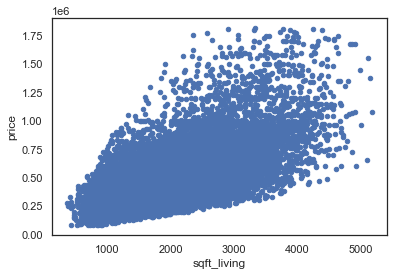

In [496]:
df_clean.plot("sqft_living","price", kind='scatter')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='sqft_living15', ylabel='price'>

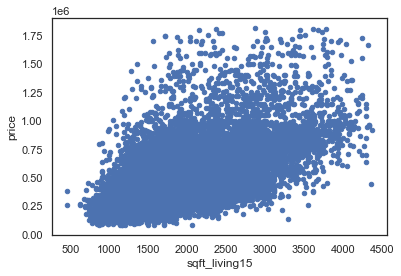

In [497]:
df_clean.plot("sqft_living15","price", kind='scatter')

Create qq plots

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.422
Model:                            OLS   Adj. R-squared:                  0.422
Method:                 Least Squares   F-statistic:                 1.383e+04
Date:                Fri, 01 Apr 2022   Prob (F-statistic):               0.00
Time:                        14:23:42   Log-Likelihood:            -2.5684e+05
No. Observations:               18951   AIC:                         5.137e+05
Df Residuals:                   18949   BIC:                         5.137e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -6.424e+05   9692.046    -66.286      0.0

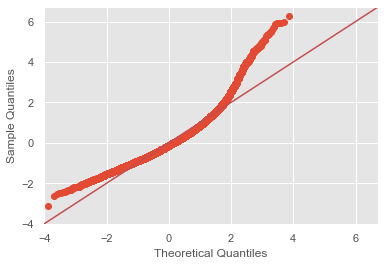

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.417
Model:                            OLS   Adj. R-squared:                  0.417
Method:                 Least Squares   F-statistic:                 1.358e+04
Date:                Fri, 01 Apr 2022   Prob (F-statistic):               0.00
Time:                        14:23:42   Log-Likelihood:            -2.5691e+05
No. Observations:               18951   AIC:                         5.138e+05
Df Residuals:                   18949   BIC:                         5.138e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     8.06e+04   3736.678     21.570      

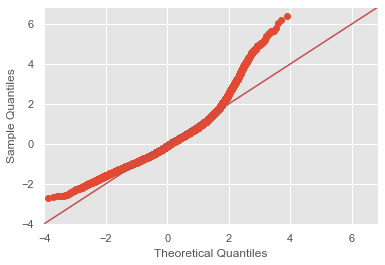

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.325
Model:                            OLS   Adj. R-squared:                  0.324
Method:                 Least Squares   F-statistic:                     9103.
Date:                Fri, 01 Apr 2022   Prob (F-statistic):               0.00
Time:                        14:23:42   Log-Likelihood:            -2.5831e+05
No. Observations:               18951   AIC:                         5.166e+05
Df Residuals:                   18949   BIC:                         5.166e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      5.175e+04   4783.491     10.819

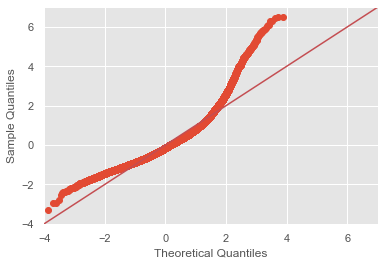

In [498]:
plt.style.use('ggplot')

f = 'price~grade'
f2 = 'price~sqft_living'
f3 = 'price~sqft_living15'

model = ols(formula=f, data=df_clean).fit()
model2 = ols(formula=f2, data=df_clean).fit()
model3 = ols(formula=f3, data=df_clean).fit()

resid1 = model.resid
resid2 = model2.resid
resid3 = model3.resid

print(model.summary())

fig = sm.graphics.qqplot(resid1, dist=stats.norm, line='45', fit=True)
plt.show()
print(model2.summary())
fig2 = sm.graphics.qqplot(resid2, dist=stats.norm, line='45', fit=True)
plt.show()
fig3 = sm.graphics.qqplot(resid3, dist=stats.norm, line='45', fit=True)
print(model3.summary())
plt.show()

## Create Initial Model

In [499]:
f = 'price~grade+sqft_living+sqft_living15'
model = ols(formula=f, data=df_clean).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.485
Model:                            OLS   Adj. R-squared:                  0.485
Method:                 Least Squares   F-statistic:                     5949.
Date:                Fri, 01 Apr 2022   Prob (F-statistic):               0.00
Time:                        14:23:42   Log-Likelihood:            -2.5574e+05
No. Observations:               18951   AIC:                         5.115e+05
Df Residuals:                   18947   BIC:                         5.115e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -3.939e+05   1.05e+04    -37.500      0.000   -4.14e+05   -3.73e+05
grade          8.185e+04   1884.157     43.439      0.000    7.82e+04    8.55e+04
sqft_living     103.5105      2.811     36.820      0.000      98.000     109.021
sqft_living15    30.1792      3.296      9.156      0.000      23.719      36.640
==============================================================================
Omnibus:                     4293.239   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12545.476
Skew:                           1.183   Prob(JB):                         0.00
Kurtosis:                       6.208   Cond. No.                     2.43e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.43e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Results

Based on the r2 score, .48, this is very low. 

## Re-explore

Create histograms

In [500]:
scaler = StandardScaler()
for i in df_clean.columns:
    col_data = df_clean[i].values.reshape(-1,1)
    scale_data = scaler.fit_transform(col_data)
    new_name = i + '_sca'
    df_clean[new_name] = scale_data.flatten()


/var/folders/8y/cslj48jd39z6f0kr2m9qqjy00000gn/T/ipykernel_76621/2691878802.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[new_name] = scale_data.flatten()
/var/folders/8y/cslj48jd39z6f0kr2m9qqjy00000gn/T/ipykernel_76621/2691878802.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[new_name] = scale_data.flatten()
/var/folders/8y/cslj48jd39z6f0kr2m9qqjy00000gn/T/ipykernel_76621/2691878802.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

Create new heatmap


/var/folders/8y/cslj48jd39z6f0kr2m9qqjy00000gn/T/ipykernel_76621/179094617.py:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


<AxesSubplot:>

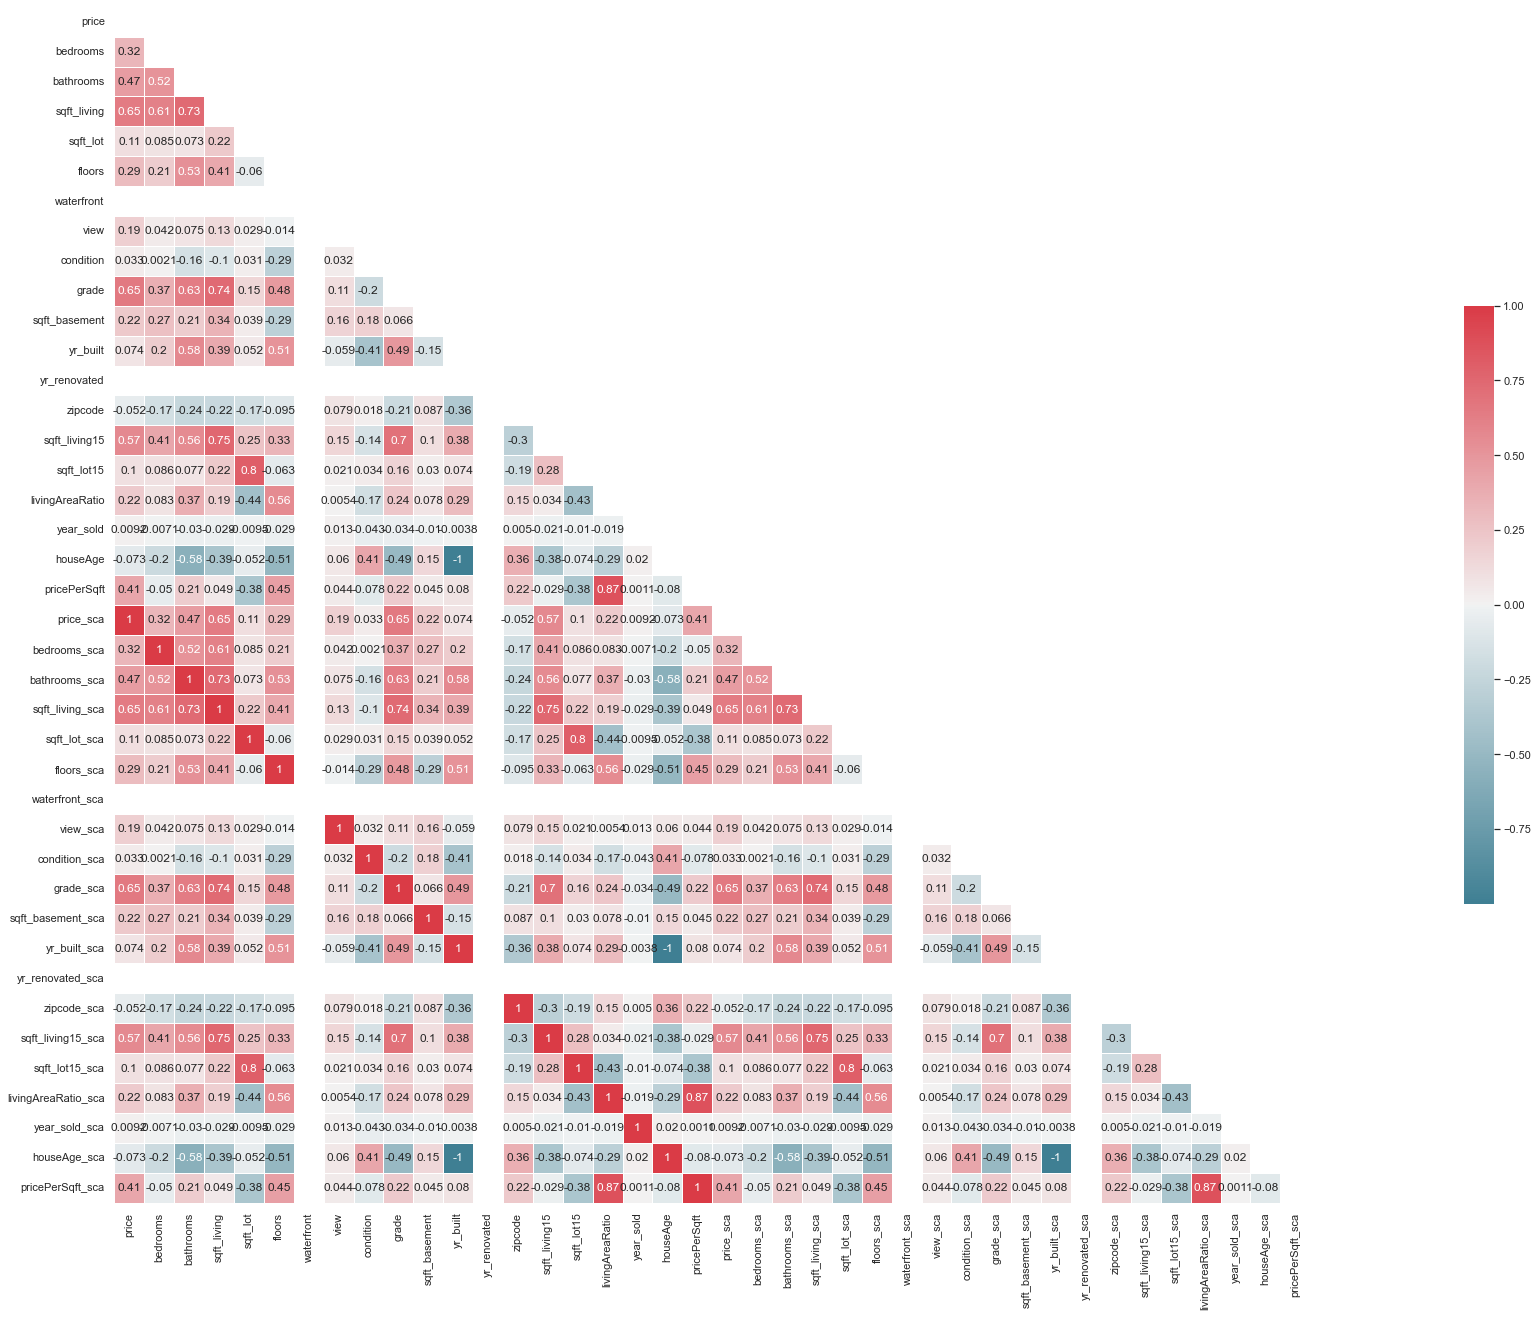

In [501]:
sns.set(style="white")
#Correlations are low - good thing?


# Compute the correlation matrix
corr = df_clean.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(55, 22))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

In [502]:
df_clean.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_basement', 'yr_built',
       'yr_renovated', 'zipcode', 'sqft_living15', 'sqft_lot15',
       'livingAreaRatio', 'year_sold', 'houseAge', 'pricePerSqft', 'price_sca',
       'bedrooms_sca', 'bathrooms_sca', 'sqft_living_sca', 'sqft_lot_sca',
       'floors_sca', 'waterfront_sca', 'view_sca', 'condition_sca',
       'grade_sca', 'sqft_basement_sca', 'yr_built_sca', 'yr_renovated_sca',
       'zipcode_sca', 'sqft_living15_sca', 'sqft_lot15_sca',
       'livingAreaRatio_sca', 'year_sold_sca', 'houseAge_sca',
       'pricePerSqft_sca'],
      dtype='object')

In [503]:
df_clean.drop(columns = ['bedrooms', 'bathrooms','sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_basement', 'yr_built', 'yr_renovated', 'sqft_living15', 'sqft_lot15', 'livingAreaRatio', 'year_sold', 'houseAge', 'pricePerSqft', 'price_sca','yr_renovated_sca', 'waterfront_sca','zipcode_sca','pricePerSqft_sca'],inplace=True)

/var/folders/8y/cslj48jd39z6f0kr2m9qqjy00000gn/T/ipykernel_76621/4247632582.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean.drop(columns = ['bedrooms', 'bathrooms','sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_basement', 'yr_built', 'yr_renovated', 'sqft_living15', 'sqft_lot15', 'livingAreaRatio', 'year_sold', 'houseAge', 'pricePerSqft', 'price_sca','yr_renovated_sca', 'waterfront_sca','zipcode_sca','pricePerSqft_sca'],inplace=True)


Recreate scatter plots


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='grade_sca', ylabel='price'>

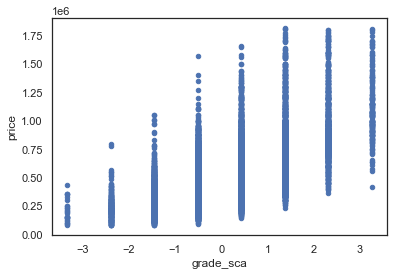

In [504]:
df_clean.plot("grade_sca","price", kind='scatter')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='sqft_living_sca', ylabel='price'>

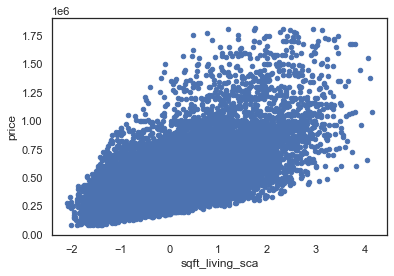

In [505]:
df_clean.plot("sqft_living_sca","price", kind='scatter')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='sqft_living15_sca', ylabel='price'>

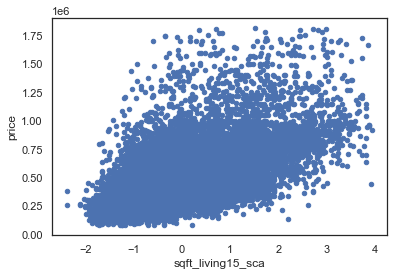

In [506]:
df_clean.plot("sqft_living15_sca","price", kind='scatter')

Create updated qq plots

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.422
Model:                            OLS   Adj. R-squared:                  0.422
Method:                 Least Squares   F-statistic:                 1.383e+04
Date:                Fri, 01 Apr 2022   Prob (F-statistic):               0.00
Time:                        14:23:46   Log-Likelihood:            -2.5684e+05
No. Observations:               18951   AIC:                         5.137e+05
Df Residuals:                   18949   BIC:                         5.137e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4.863e+05   1351.412    359.875      0.0

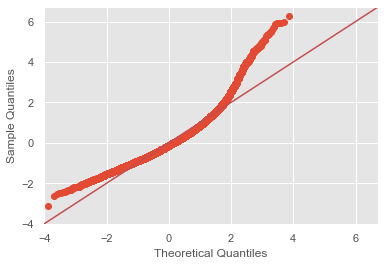

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.417
Model:                            OLS   Adj. R-squared:                  0.417
Method:                 Least Squares   F-statistic:                 1.358e+04
Date:                Fri, 01 Apr 2022   Prob (F-statistic):               0.00
Time:                        14:23:46   Log-Likelihood:            -2.5691e+05
No. Observations:               18951   AIC:                         5.138e+05
Df Residuals:                   18949   BIC:                         5.138e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        4.863e+05   1356.650    3

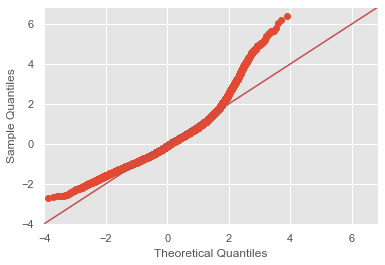

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.325
Model:                            OLS   Adj. R-squared:                  0.324
Method:                 Least Squares   F-statistic:                     9103.
Date:                Fri, 01 Apr 2022   Prob (F-statistic):               0.00
Time:                        14:23:46   Log-Likelihood:            -2.5831e+05
No. Observations:               18951   AIC:                         5.166e+05
Df Residuals:                   18949   BIC:                         5.166e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          4.863e+05   1460.91

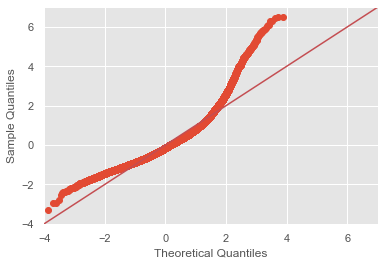

In [507]:
plt.style.use('ggplot')

f = 'price~grade_sca'
f2 = 'price~sqft_living_sca'
f3 = 'price~sqft_living15_sca'

model = ols(formula=f, data=df_clean).fit()
model2 = ols(formula=f2, data=df_clean).fit()
model3 = ols(formula=f3, data=df_clean).fit()

resid1 = model.resid
resid2 = model2.resid
resid3 = model3.resid

print(model.summary())

fig = sm.graphics.qqplot(resid1, dist=stats.norm, line='45', fit=True)
plt.show()
print(model2.summary())
fig2 = sm.graphics.qqplot(resid2, dist=stats.norm, line='45', fit=True)
plt.show()
fig3 = sm.graphics.qqplot(resid3, dist=stats.norm, line='45', fit=True)
print(model3.summary())
plt.show()

Create Updated Model - Including Zipcodes

In [508]:
f = 'price~grade_sca+sqft_living_sca+sqft_living15_sca+C(zipcode)'
model = ols(formula=f, data=df_clean).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     1176.
Date:                Fri, 01 Apr 2022   Prob (F-statistic):               0.00
Time:                        14:23:47   Log-Likelihood:            -2.4590e+05
No. Observations:               18951   AIC:                         4.919e+05
Df Residuals:                   18878   BIC:                         4.925e+05
Df Model:                          72                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            3.049e+05   5607.223     54.368      0.000    2.94e+05    3.16e+05
C(zipcode)[T.98002]  2.883e+04   9424.381      3.059      0.002    1.04e+04    4.73e+04
C(zipcode)[T.98003]   394.3997   8496.292      0.046      0.963   -1.63e+04     1.7e+04
C(zipcode)[T.98004]  6.608e+05   9036.678     73.124      0.000    6.43e+05    6.79e+05
C(zipcode)[T.98005]  3.328e+05   1.03e+04     32.250      0.000    3.13e+05    3.53e+05
C(zipcode)[T.98006]  2.731e+05   7807.400     34.974      0.000    2.58e+05    2.88e+05
C(zipcode)[T.98007]  2.602e+05   1.06e+04     24.558      0.000    2.39e+05    2.81e+05
C(zipcode)[T.98008]  2.485e+05   8625.175     28.816      0.000    2.32e+05    2.65e+05
C(zipcode)[T.98010]  9.508e+04   1.36e+04      7.017      0.000    6.85e+04    1.22e+05
C(zipcode)[T.98011]  1.319e+05   9536.782     13.826      0.000    1.13e+05    1.51e+05
C(zipcode)[T.98014]  1.244e+05   1.24e+04     10.006      0.000       1e+05    1.49e+05
C(zipcode)[T.98019]  8.146e+04   9961.255      8.178      0.000    6.19e+04    1.01e+05
C(zipcode)[T.98022]  3.012e+04   9953.033      3.027      0.002    1.06e+04    4.96e+04
C(zipcode)[T.98023] -2.526e+04   7354.789     -3.435      0.001   -3.97e+04   -1.08e+04
C(zipcode)[T.98024]  1.643e+05   1.63e+04     10.099      0.000    1.32e+05    1.96e+05
C(zipcode)[T.98027]  1.888e+05   8042.042     23.478      0.000    1.73e+05    2.05e+05
C(zipcode)[T.98028]  1.268e+05   8491.214     14.938      0.000     1.1e+05    1.43e+05
C(zipcode)[T.98029]  2.138e+05   8233.980     25.965      0.000    1.98e+05     2.3e+05
C(zipcode)[T.98030] -1101.5236   8663.569     -0.127      0.899   -1.81e+04    1.59e+04
C(zipcode)[T.98031]  1.055e+04   8484.414      1.243      0.214   -6079.941    2.72e+04
C(zipcode)[T.98032]  6541.6725    1.1e+04      0.592      0.554   -1.51e+04    2.82e+04
C(zipcode)[T.98033]  3.645e+05   7753.948     47.008      0.000    3.49e+05     3.8e+05
C(zipcode)[T.98034]  1.887e+05   7246.780     26.043      0.000    1.75e+05    2.03e+05
C(zipcode)[T.98038]  2.257e+04   7205.831      3.132      0.002    8443.952    3.67e+04
C(zipcode)[T.98039]  8.558e+05   2.61e+04     32.851      0.000    8.05e+05    9.07e+05
C(zipcode)[T.98040]  5.052e+05   9308.280     54.278      0.000    4.87e+05    5.23e+05
C(zipcode)[T.98042]  6440.0869   7239.896      0.890      0.374   -7750.758    2.06e+04
C(zipcode)[T.98045]  1.111e+05   9503.510     11.691      0.000    9.25e+04     1.3e+05
C(zipcode)[T.98052]   2.44e+05   7199.056     33.887      0.000     2.3e+05    2.58e+05
C(zipcode)[T.98053]  2.273e+05   7934.007     28.649      0.000    2.12e+05    2.43e+05
C(zipcode)[T.98055]  4.627e+04   8605.028      5.377      0.000    2.94e+04    6.31e+04
C(zipcode)[T.98056]  1.094e+05   7695.100     14.214      0.000    9.43e+04    1.24e+05
C(z

show model.params

In [509]:
model.params

Intercept              304851.242019
C(zipcode)[T.98002]     28829.261418
C(zipcode)[T.98003]       394.399672
C(zipcode)[T.98004]    660795.869460
C(zipcode)[T.98005]    332766.589775
                           ...      
C(zipcode)[T.98198]     36954.161375
C(zipcode)[T.98199]    392301.318493
grade_sca               49336.707066
sqft_living_sca         93027.739133
sqft_living15_sca       22640.108108
Length: 73, dtype: float64

In [510]:
from sklearn.model_selection import train_test_split
X = df_clean.drop('price', axis=1)
y = df_clean['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


In [511]:
df_train = pd.DataFrame(X_train, columns = X.columns)
df_train['price'] = y_train
df_test = pd.DataFrame(X_test, columns = X.columns)
df_test['price'] = y_test

In [512]:
from sklearn.metrics import r2_score
y_hat_test = model.predict(df_test)
r2_score(y_test, y_hat_test)

0.8309738301524886

Conclusions & Recommendations

Zipcode
Living square footage
High quality construction and materials


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


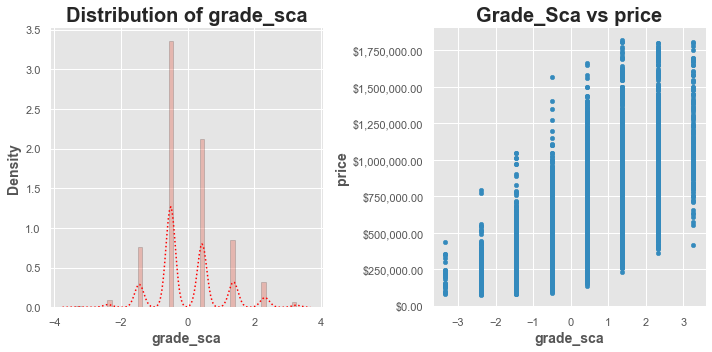

In [513]:
def eda_plot(df_clean, col = 'grade_sca', target='price',
            figsize=(10,5),hist_kws = None, kde_kws = None):
    # Lets write our plot together

    fig, axes = plt.subplots(ncols=2,figsize=figsize)

    ax = axes[0]
    
    
    if hist_kws is None:
        hist_kws = {'edgecolor':'black',
                   'alpha':0.3}
        
    if kde_kws is None:
        kde_kws = {'color':'black'}
    
    sns.distplot(df_clean[col],ax=ax,kde_kws=kde_kws, hist_kws=hist_kws)

    label_fonts = {'weight':'bold',
                  'size':14}
    title_fonts = {'weight':'bold',
                  'size':20}

    ax.set_title(f'Distribution of {col}',fontdict=title_fonts)


    ax.set_ylabel('Density',fontdict=label_fonts)
    ax.set_xlabel(ax.get_xlabel(),fontdict=label_fonts)

    ax = axes[1]
    x_samp = df_clean[col]
    y_samp = df_clean[target]

    beta_1 = np.cov(x_samp, y_samp)[0][1]/x_samp.var()
    beta_0 = y_samp.mean() - beta_1*x_samp.mean()

    df_clean.plot(kind='scatter',x=col,y=target,ax=ax)
    ax.set_title(f"{col.title()} vs {target}",fontdict=title_fonts)
    ax.set_ylabel(ax.get_ylabel(),fontdict=label_fonts)
    ax.set_xlabel(ax.get_xlabel(),fontdict=label_fonts)
    
    
#     fmtPrice = '${x:,.0f}'

    tick_format = StrMethodFormatter('${x:,.2f}')
    ax.yaxis.set_major_formatter(tick_format)
        # Formatting dollar sign labels
#     tickPrice = mtick.StrMethodFormatter(fmtPrice)


    plt.tight_layout()
    plt.show()
    
    return fig, axes
    
f,a = eda_plot(df_clean,col='grade_sca',kde_kws={'color':'red','ls':':'})

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


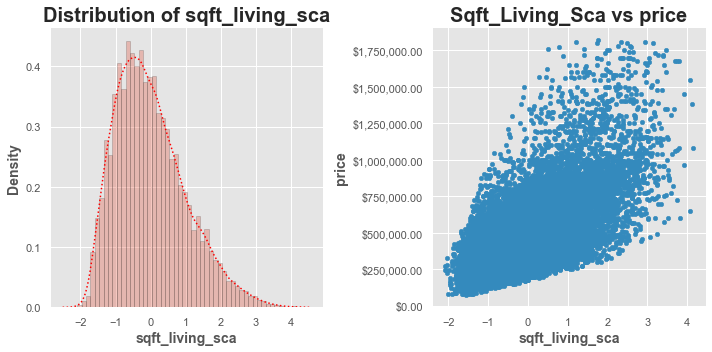

In [514]:
f,a = eda_plot(df_clean,col='sqft_living_sca',kde_kws={'color':'red','ls':':'})

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


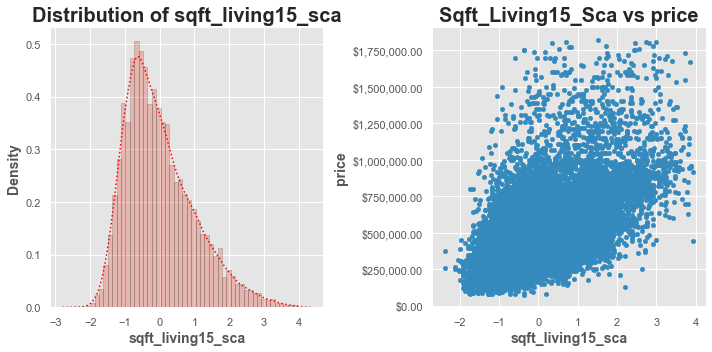

In [515]:
f,a = eda_plot(df_clean,col='sqft_living15_sca',kde_kws={'color':'red','ls':':'})

# Price Predict base on this three feature

In [516]:
lr = LinearRegression()
lr

LinearRegression()

In [517]:
data.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_basement,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15,livingAreaRatio,year_sold,houseAge,pricePerSqft
0,221900.0,3,1.00,1180,5650,1.0,0,0,0,7,...,0.0,1955,0.0,98178,1340,5650,0.208850,2014,59,39.274336
1,538000.0,3,2.25,2570,7242,2.0,0,0,0,7,...,400.0,1951,1991.0,98125,1690,7639,0.354874,2014,63,74.288870
2,180000.0,2,1.00,770,10000,1.0,0,0,0,6,...,0.0,1933,0.0,98028,2720,8062,0.077000,2015,82,18.000000
3,604000.0,4,3.00,1960,5000,1.0,0,0,4,7,...,910.0,1965,0.0,98136,1360,5000,0.392000,2014,49,120.800000
4,510000.0,3,2.00,1680,8080,1.0,0,0,0,8,...,0.0,1987,0.0,98074,1800,7503,0.207921,2015,28,63.118812


In [518]:
X = data[['sqft_living', 'zipcode', 'sqft_living15','grade']]
Y = data['price']
X.head()

,sqft_living,zipcode,sqft_living15,grade
0,1180,98178,1340,7
1,2570,98125,1690,7
2,770,98028,2720,6
3,1960,98136,1360,7
4,1680,98074,1800,8


In [519]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.3)
print(len(X_train), len(Y_train))

15117 15117


Creating our prediction machine

In [520]:
lr.fit(X_train,Y_train)

LinearRegression()

Get the "learned" weights:

In [521]:
print(lr.coef_, lr.intercept_)


[1.76960776e+02 7.49322529e+02 3.47640250e+01 9.37646439e+04] -74107603.7434066


In [522]:
X.columns

Index(['sqft_living', 'zipcode', 'sqft_living15', 'grade'], dtype='object')

In [523]:
lr.score(X_train,Y_train)


0.5441732588482897

Evaluating our model on the test data

In [524]:
Y_pred = lr.predict(X_test)
Y_pred[0:10]

array([ 318631.62937117,  369752.29185642, 1219843.45898037,
        694643.10421248, 1046167.66647515,  340566.28055669,
        657095.69579394,  525856.3801572 ,  543086.38295621,
        293709.92644045])

Evaluate model prediction on test set:

In [525]:
MAE = mean_absolute_error(Y_pred, Y_test)
MAE

157951.74044584285

In [526]:
RMSE = np.sqrt(mean_squared_error(Y_pred,Y_test))
RMSE

248366.88985569525

In [527]:
%%capture price_test
fig, ax = plt.subplots()
Y_test.hist(bins='auto', ax=ax)
ax.set_xlabel("price")
ax.set_ylabel("Counts")
ax.set_title('price expectancy: test distribution')
plt.show()

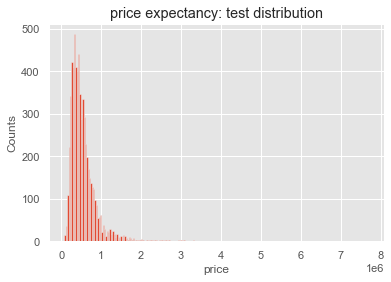

In [528]:
price_test()

In [529]:
examp_idx = 10
single_examp = X_test.iloc[examp_idx].values
X_test.iloc[examp_idx]

sqft_living       3030
zipcode          98059
sqft_living15     3030
grade                8
Name: 20977, dtype: int64

In [530]:
lr.predict(single_examp.reshape(1,-1))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([761857.456176])

In [531]:
Y_test.iloc[examp_idx]

525000.0

try it to a house over 110 year and pricePerSqft more than 300

In [532]:
data[['price', 'sqft_living', 'zipcode', 'sqft_living15', 'grade']].head()


,price,sqft_living,zipcode,sqft_living15,grade
0,221900.0,1180,98178,1340,7
1,538000.0,2570,98125,1690,7
2,180000.0,770,98028,2720,6
3,604000.0,1960,98136,1360,7
4,510000.0,1680,98074,1800,8


In [533]:
target_house_dict = {'sqft_living':1180, 'zipcode':98178, 'sqft_living15':1340, 'grade':7}
X_target_house = pd.Series(target_house_dict)

In [534]:
X_target_house_np = X_target_house.values
X_target_house_np

array([ 1180, 98178,  1340,     7])

In [535]:
X_target_house_input = X_target_house_np.reshape(1,-1)
X_target_house_input

array([[ 1180, 98178,  1340,     7]])

In [536]:
lr.predict(X_target_house_input)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([371133.55499807])

In [537]:
percent_change = (lr.predict(X_target_house_input)[0] - 221900.0 ) / 221900.0 * 100
print(percent_change)

67.25261604239296


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
